<a href="https://colab.research.google.com/github/ABD-01/Siamese-Triplet/blob/master/Siamese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import numpy as np
import random
import matplotlib.pyplot as plt
from itertools import combinations 
from collections import OrderedDict
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
 
import torchvision
import torchvision.transforms as transforms

In [20]:
torch.cuda.is_available()

True

In [21]:
import sklearn
from sklearn import datasets

In [22]:
lfw_pairs = datasets.fetch_lfw_pairs(
    subset='train',
    data_home="/content/drive/MyDrive/Colab Notebooks/lfw",
    funneled=False,
    resize=1,
    color=True,
    download_if_missing=True
    )
# ref : https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_pairs.html

In [23]:
lfw_pairs.keys()

dict_keys(['data', 'pairs', 'target', 'target_names', 'DESCR'])

In [24]:
pairDevTrain = open("/content/drive/MyDrive/Colab Notebooks/lfw/lfw_home/pairsDevTrain.txt").readlines()[1:]

Nicolas_Lapentti	1	Paula_Dobriansky	1

Different persons


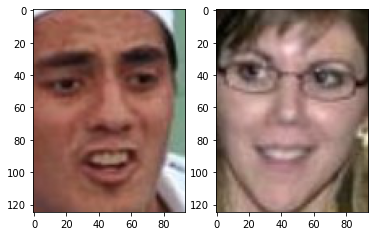

In [8]:
index = 2109
_, axxar = plt.subplots(1,2)
axxar[0].imshow(lfw_pairs.pairs[index][0] / 255)
axxar[1].imshow(lfw_pairs.pairs[index][1] / 255)
print(pairDevTrain[index])
print(lfw_pairs.target_names[lfw_pairs.target[index]])

In [25]:
lfw_people = datasets.fetch_lfw_people(
    data_home="/content/drive/MyDrive/Colab Notebooks/LFW",
    min_faces_per_person=2,
    resize=1,
    color=True,
    download_if_missing=True
)

In [10]:
lfw_people.data.shape

(9164, 35250)

In [11]:
lfw_people.images.shape

(9164, 125, 94, 3)

In [ ]:
np.moveaxis(lfw_people.images, -1,-3).shape

In [ ]:
lfw_people.keys()

In [ ]:
randomstate = np.random.RandomState(seed=None)

In [ ]:
no_of_classes = len(lfw_people.target_names)

In [ ]:
pos_class = randomstate.choice(no_of_classes)
neg_class = randomstate.choice(no_of_classes)
while pos_class == neg_class:
    neg_class = randomstate.choice(classes_per_batch)
pos_class, neg_class

In [ ]:
pos_name = lfw_people.target_names[pos_class]
neg_name = lfw_people.target_names[neg_class]
pos_name, neg_name

In [ ]:
pos_imgs = lfw_people.images[lfw_people.target == pos_class]
neg_imgs = lfw_people.images[lfw_people.target == neg_class]
pos_imgs.shape[0], neg_imgs.shape[0]

In [ ]:
if pos_imgs.shape[0] == 2:
    ianc, ipos = 0,1
else:
    ianc = randomstate.randint(0, pos_imgs.shape[0])
    ipos = randomstate.randint(0, pos_imgs.shape[0])
    while ianc == ipos:
        ipos = randomstate.randint(0, len(face_classes[pos_class]))

In [ ]:
ineg = randomstate.randint(0, neg_imgs.shape[0])

In [ ]:
_,axxar = plt.subplots(1,3)
axxar[0].imshow(pos_imgs[ianc] / 255)
axxar[1].imshow(pos_imgs[ipos] / 255)
axxar[2].imshow(neg_imgs[ineg] / 255)
print(f'Pos_class : {pos_name}, Neg_class : {neg_class}')

In [26]:
def get_random_triplets(no_classes:int, images, target, no_triplets:int):
    # Ref : https://github.com/tamerthamoqa/facenet-pytorch-vggface2/blob/master/datasets/TripletLossDataset.py#L76-L136
    randomstate = np.random.RandomState(seed=None)
    # no_class = len(lfw_people.target_names)
    triplets = []
    class_pairs = []

    ###
    # _,axxar = plt.subplots(no_triplets,3, figsize=(7,5))
    # plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
    # # ref : https://stackoverflow.com/questions/25124143/matplotlib-subplots-get-rid-of-tick-labels-altogether
    ###

    # progress_bar = tqdm(range(no_triplets), desc='fetching triplets')
    for progress in range(no_triplets):

        pos_class = randomstate.choice(no_classes)
        neg_class = randomstate.choice(no_classes)
        while pos_class == neg_class:
            neg_class = randomstate.choice(no_classes)

        # pos_name = lfw_people.target_names[pos_class]
        # neg_name = lfw_people.target_names[neg_class]

        pos_imgs = images[target == pos_class]
        neg_imgs = images[target == neg_class]

        if pos_imgs.shape[0] == 2:
            ianc, ipos = 0,1
        else:
            ianc = randomstate.randint(0, pos_imgs.shape[0])
            ipos = randomstate.randint(0, pos_imgs.shape[0])
            while ianc == ipos:
                ipos = randomstate.randint(0, pos_imgs.shape[0])
        ineg = randomstate.randint(0, neg_imgs.shape[0])

        ####
        # axxar[progress][0].imshow(pos_imgs[ianc] / 255)
        # axxar[progress][0].set_title(lfw_people.target_names[pos_class])
        # axxar[progress][1].imshow(pos_imgs[ipos] / 255)
        # axxar[progress][1].set_title(lfw_people.target_names[pos_class])
        # axxar[progress][2].imshow(neg_imgs[ineg] / 255)
        # axxar[progress][2].set_title(lfw_people.target_names[neg_class])
        ####

        triplets.append(
            torch.stack([
                torch.from_numpy(pos_imgs[ianc] / 255), 
                torch.from_numpy(pos_imgs[ipos] / 255), 
                torch.from_numpy(neg_imgs[ineg] / 255)
            ]))
        class_pairs.append((pos_class, neg_class))

    return torch.stack(triplets) , class_pairs

In [35]:
triplets, class_pairs = get_random_triplets(no_classes=len(lfw_people.target_names), images=lfw_people.images, target=lfw_people.target, no_triplets=500)

In [36]:
triplets.shape

torch.Size([2200, 3, 125, 94, 3])

In [ ]:
triplets.shape

torch.Size([3, 3, 125, 94, 3])

In [ ]:
triplets.shape

torch.Size([3, 3, 125, 94, 3])

# Model

In [153]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.convnet1 = nn.Sequential(OrderedDict([
                            ('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(7,5))),
                            ('conv2', nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(5,5))),
                            ('norm', nn.BatchNorm2d(32)),
                            # ('actv', nn.Tanh()),
                            ('pool', nn.MaxPool2d(kernel_size=3, stride=2))
        ]))
        # ref : https://discuss.pytorch.org/t/is-it-possible-to-specify-a-name-for-each-layer-when-creating-the-model/33637/2

        self.convnet2 = nn.Sequential(OrderedDict([
                            ('conv1', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)),
                            ('conv2', nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)),
                            ('norm', nn.BatchNorm2d(64)),
                            # ('actv', nn.Tanh()),
                            ('pool', nn.MaxPool2d(kernel_size=3, stride=2))
        ]))

        self.convnet3 = nn.Sequential(OrderedDict([
                            ('conv1', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)),
                            ('conv2', nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3)),
                            ('norm', nn.BatchNorm2d(128)),
                            # ('actv', nn.Tanh()),
                            ('pool', nn.MaxPool2d(kernel_size=3, stride=2))
        ]))

        self.FCs      = nn.Sequential(OrderedDict([
                            ('FC1', nn.Linear(in_features=7680, out_features=2048)),
                            ('relu1', nn.ReLU(inplace=True)),
                            ('FC2', nn.Linear(in_features=2048, out_features=512)),
                            ('relu2', nn.ReLU(inplace=True)),
                            ('FC3', nn.Linear(in_features=512, out_features=128)),
                            ('relu3', nn.ReLU(inplace=True)),
        ]))

        # self.out      = nn.Linear(in_features=128, out_features=2)

        # for m in self.modules():
        #     classname = m.__class__.__name__
        #     if classname.find('Conv') != -1:
        #         nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')  # He-initialization
                # ref : https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_

    def semi_forward(self, x):
        x = self.convnet1(x)
        x = self.convnet2(x)
        x = self.convnet3(x)
        # x = x.view(-1, 10*6*128)
        x = x.reshape(-1, 10*6*128)
        x = self.FCs(x)
        return x

    def forward(self,triplet):
        triplet = triplet.movedim(-1, -3)
        anc = self.semi_forward(triplet[:,0,...])
        pos = self.semi_forward(triplet[:,1,...])
        neg = self.semi_forward(triplet[:,2,...])
        return [anc, pos, neg]

In [72]:
x = torch.rand(10, 3, 125, 94, 3)
print(x.shape)
x = x.movedim(-1, -3)
print(x.shape)
print(x[:,0,...].shape)
x = model.convnet1(x[:,0,...])
print(x.shape)
x = model.convnet2(x)
print(x.shape)
x = model.convnet3(x)
print(x.shape)
x = x.view(-1, 10*6*128)
print(x.shape)
x = model.FCs(x)
print(x.shape)
print()
x = torch.rand(10, 3, 125, 94, 3)
# x = x.movedim(-1, -3)
x = model(x)
print(x[0].shape)

torch.Size([10, 128])


In [38]:
model = Model()
model

Model(
  (convnet1): Sequential(
    (conv1): Conv2d(3, 32, kernel_size=(7, 5), stride=(1, 1))
    (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
    (relu): ReLU(inplace=True)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convnet2): Sequential(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (relu): ReLU(inplace=True)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convnet3): Sequential(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (relu): Re

In [70]:
class ResModel(nn.Module):
    def __init__(self):
        super(ResModel, self).__init__()

        self.resnet = torchvision.models.resnet18()
        self.linear = nn.Linear(1000, 128)

    def semi_forward(self,x):
        x = self.resnet(x)
        x = self.linear(x)
        return x

    def forward(self, triplet):
        triplet = triplet.movedim(-1, -3)
        anc = self.semi_forward(triplet[:,0,...])
        pos = self.semi_forward(triplet[:,1,...])
        neg = self.semi_forward(triplet[:,2,...])
        return [anc, pos, neg]

In [71]:
model = ResModel()
model

ResModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [ ]:
lfw_pairs.pairs[:1100].shape

(1100, 2, 125, 94, 3)

In [ ]:
lfw_pairs.pairs[1100:, 0].shape

(1100, 125, 94, 3)

In [39]:
def triplet_loss(anchor, positive, negative, margin=1):
    pos_dist = (anchor - positive).pow(2).sum(-1) #.pow(.5)
    neg_dist = (anchor - negative).pow(2).sum(-1) #.pow(.5)
    loss = F.relu(pos_dist - neg_dist + margin)
    return loss.mean()
 
# ref: https://github.com/adambielski/siamese-triplet/blob/master/losses.py#L24

In [150]:
model = Model().cuda()
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
# optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
lossfn = nn.TripletMarginLoss(margin=1, reduction='mean')

In [147]:
lfw_people.images.shape

(9164, 125, 94, 3)

In [156]:
cost = []

epochs = 100
for epoch in range(epochs):

    triplets, class_pairs = get_random_triplets(no_classes=len(lfw_people.target_names),
                                                images=lfw_people.images, 
                                                target=lfw_people.target, no_triplets=50)

    apn = model(triplets.cuda())
    # apn = model(triplets)

    optimizer.zero_grad()
    loss = triplet_loss(*apn)
    # loss = lossfn(*apn)
    cost.append(loss.item())

    loss.backward()
    optimizer.step()

    print(f'Epoch:[{epoch+1}/{epochs}] , Cost : {loss.item()}')


Epoch:[1/100] , Cost : 0.9659870862960815
Epoch:[2/100] , Cost : 0.9644672870635986
Epoch:[3/100] , Cost : 0.9621430039405823
Epoch:[4/100] , Cost : 0.9457932114601135
Epoch:[5/100] , Cost : 0.9508065581321716
Epoch:[6/100] , Cost : 0.9601650834083557
Epoch:[7/100] , Cost : 0.9946232438087463
Epoch:[8/100] , Cost : 0.9748712182044983
Epoch:[9/100] , Cost : 0.9282634258270264
Epoch:[10/100] , Cost : 0.9633216857910156
Epoch:[11/100] , Cost : 0.9397881627082825
Epoch:[12/100] , Cost : 0.987535297870636
Epoch:[13/100] , Cost : 0.942543089389801
Epoch:[14/100] , Cost : 0.9559898376464844
Epoch:[15/100] , Cost : 0.966406524181366
Epoch:[16/100] , Cost : 0.9649161100387573
Epoch:[17/100] , Cost : 0.924069881439209
Epoch:[18/100] , Cost : 0.9683732390403748
Epoch:[19/100] , Cost : 0.9473322629928589
Epoch:[20/100] , Cost : 0.931240975856781
Epoch:[21/100] , Cost : 0.9274965524673462
Epoch:[22/100] , Cost : 0.9186164736747742
Epoch:[23/100] , Cost : 0.9069063067436218
Epoch:[24/100] , Cost : 0

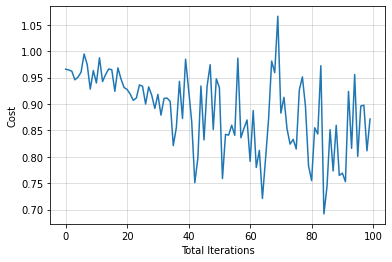

In [157]:
plt.xlabel('Total Iterations')
plt.ylabel('Cost')
plt.plot(np.arange(epochs), cost)
plt.grid(alpha=0.5)
plt.show()

In [79]:
apn[0].sum()

tensor(10616.1826, device='cuda:0', grad_fn=<SumBackward0>)

In [80]:
p = (apn[0] - apn[1]).pow(2).sum(-1)
p

tensor([4.7582, 0.8417, 0.8549, 1.5687, 3.5671, 2.4244, 1.0575, 1.8300, 2.5266,
        1.6074, 1.6238, 5.4433, 4.8846, 1.5700, 1.3195, 2.4054, 1.0962, 2.8474,
        2.0498, 1.8253, 1.5951, 3.1177, 2.0237, 1.5682, 2.1085, 3.2992, 1.9226,
        1.8915, 2.7538, 2.7667, 1.2032, 0.9316, 2.8606, 1.8528, 1.5126, 2.1997,
        3.0486, 1.5700, 2.2914, 1.7749, 9.0662, 1.5291, 2.3279, 2.1487, 3.7744,
        1.3518, 1.0076, 1.7362, 1.6959, 0.7982, 2.2287, 2.0616, 1.6123, 1.5947,
        1.8993, 2.0771, 1.5305, 2.5525, 1.6360, 0.8633, 1.9305, 3.4850, 3.2266,
        2.8542, 1.5234, 2.0806, 1.3599, 2.9940, 3.2058, 2.0035, 2.0051, 1.0682,
        2.0717, 2.1150, 3.8975, 2.0632, 1.9846, 0.8996, 3.2408, 2.6494, 2.5125,
        1.3957, 1.1325, 2.4913, 3.5072, 1.8528, 1.2668, 0.3634, 2.4512, 1.5885,
        2.7800, 3.4212, 1.5947, 1.5905, 4.3441, 3.1717, 1.2169, 3.8417, 2.2833,
        1.1515, 1.8328, 0.9272, 0.9626, 2.6118, 3.7744, 2.9842, 3.8158, 2.9056,
        1.9356, 2.5806, 1.4238, 1.5454, 

In [81]:
n = (apn[0] - apn[2]).pow(2).sum(-1)
n

tensor([ 6.4321,  6.4689,  9.5025, 11.7799,  6.4097,  3.0265,  7.2056, 10.0752,
        12.2785,  7.3363,  2.9561,  9.5039,  6.8135,  4.0238,  4.8191,  2.8854,
         1.2882,  3.3614,  6.9766,  7.3420,  2.2555,  5.4077,  9.6239, 12.2061,
         4.6474,  4.8776,  4.7230, 10.7465, 10.5317,  4.2345,  4.7214,  3.5180,
        10.6219,  3.8195,  7.5536,  9.8306, 12.7742,  4.0615,  6.9150,  2.6115,
        16.4684,  4.6439,  8.2410,  5.6419, 10.9293,  3.4033,  7.6205,  3.2737,
         2.7274, 11.9652,  6.3978,  8.6971, 10.7390, 20.5306,  7.2215,  5.0582,
         6.7096,  9.3641,  5.1327,  1.6812,  4.3028,  5.1702,  4.9111,  5.4616,
         6.4759,  1.1995,  3.0172,  4.7648, 12.7483,  3.3912,  4.7921,  6.8352,
        13.7946, 11.7863, 11.9567,  8.2697,  7.5796,  3.0548, 15.2544,  7.1318,
         3.3907,  5.9992,  5.8793,  4.4346,  8.1157,  4.4652,  8.1577,  7.4350,
         7.7674, 11.5167,  4.7034,  5.0556,  7.4058, 12.7091,  8.5600,  6.5614,
         6.6496,  2.4818,  5.2043,  2.79

In [82]:
p.max() , p.mean() , n.max(), n.mean()

(tensor(9.0662, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(2.0554, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(23.3186, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(6.4435, device='cuda:0', grad_fn=<MeanBackward0>))

In [27]:
(p-n).mean()

tensor(-14.9492, device='cuda:0', grad_fn=<MeanBackward0>)

In [40]:
(F.relu(p-n + 1)).mean()

tensor(0.6459, device='cuda:0', grad_fn=<MeanBackward0>)

In [41]:
# model.load_state_dict(torch.load(PATH))
# model.eval()

In [83]:
def dist(enc1,enc2):
    return (enc1 - enc2).pow(2).sum(-1)
    

In [101]:
loader = torch.utils.data.DataLoader(lfw_pairs.pairs, batch_size=100)

In [102]:
len(loader)

22

In [103]:
sample = next(iter(loader))
sample.shape

torch.Size([100, 2, 125, 94, 3])

In [104]:
pred = []

In [105]:
for sample in loader:
    test1 = sample[:,0,...].cuda() /255
    test2 = sample[:,1,...].cuda() /255
    enc1 = model.semi_forward(test1.movedim(-1,-3))
    enc2 = model.semi_forward(test2.movedim(-1,-3))
    d = dist(enc1,enc2)
    pred.append(d.cpu().detach().numpy())

In [106]:
pre = [torch.tensor(a) for a in pred]

In [107]:
PRED = torch.cat(pre)

In [108]:
PRED.shape

torch.Size([2200])

In [118]:
same_pred = PRED <= 3

In [120]:
same_pred[:1100].sum()

tensor(715)

In [121]:
same_pred[:1100].sum() / 1100 , "% age accuracy on Same person"

(tensor(0.6500), '% age accuracy on Same person')

In [122]:
same_pred[1100:].sum()

tensor(199)

In [123]:
same_pred[1100:].sum() / 1100 , "% age error on Different person"

(tensor(0.1809), '% age error on Different person')

In [129]:
index = 2019
test1 = torch.from_numpy(lfw_pairs.pairs[index][0]).cuda() /255
test2 = torch.from_numpy(lfw_pairs.pairs[index][1]).cuda() /255
enc1 = model.semi_forward(test1.movedim(-1,-3).unsqueeze(0))
enc2 = model.semi_forward(test2.movedim(-1,-3).unsqueeze(0))
d = dist(enc1,enc2)
print(d)
print('Different Person') if d > 3 else print('Same Person')

tensor([0.4264], device='cuda:0', grad_fn=<SumBackward1>)
Same Person


Abner_Martinez	1	Andre_Techine	1

Different persons


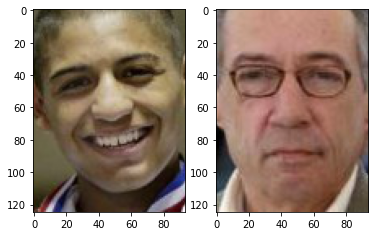

In [85]:
# Testing
# index = 3
_, axxar = plt.subplots(1,2)
axxar[0].imshow(lfw_pairs.pairs[index][0] / 255)
axxar[1].imshow(lfw_pairs.pairs[index][1] / 255)
print(pairDevTrain[index])
print(lfw_pairs.target_names[lfw_pairs.target[index]])

In [ ]:
a = next(iter(LOADER))

In [ ]:
a.shape

torch.Size([10, 2, 125, 94, 3])

In [ ]:
model = model.cuda()

In [ ]:
!nvidia-smi

Tue Feb  9 13:19:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    74W / 149W |  11348MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
torch.cuda.empty_cache()

In [ ]:
torch.cuda.reset_max_memory_allocated()

/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:234: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)


In [65]:
# Saving the state_dict of Model
PATH = '/content/drive/MyDrive/Colab Notebooks/siamese'

In [66]:
# torch.save(model.state_dict(), PATH)

In [ ]:
# ColabCode(port=100, password='12345')

## .

In [ ]:
!pip install torchviz

     |████████████████████████████████| 51kB 7.7MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3522 sha256=ec58767d618243e986be401fd4ad7f2f847e329e53c26d5a9e189caa732dbc32
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


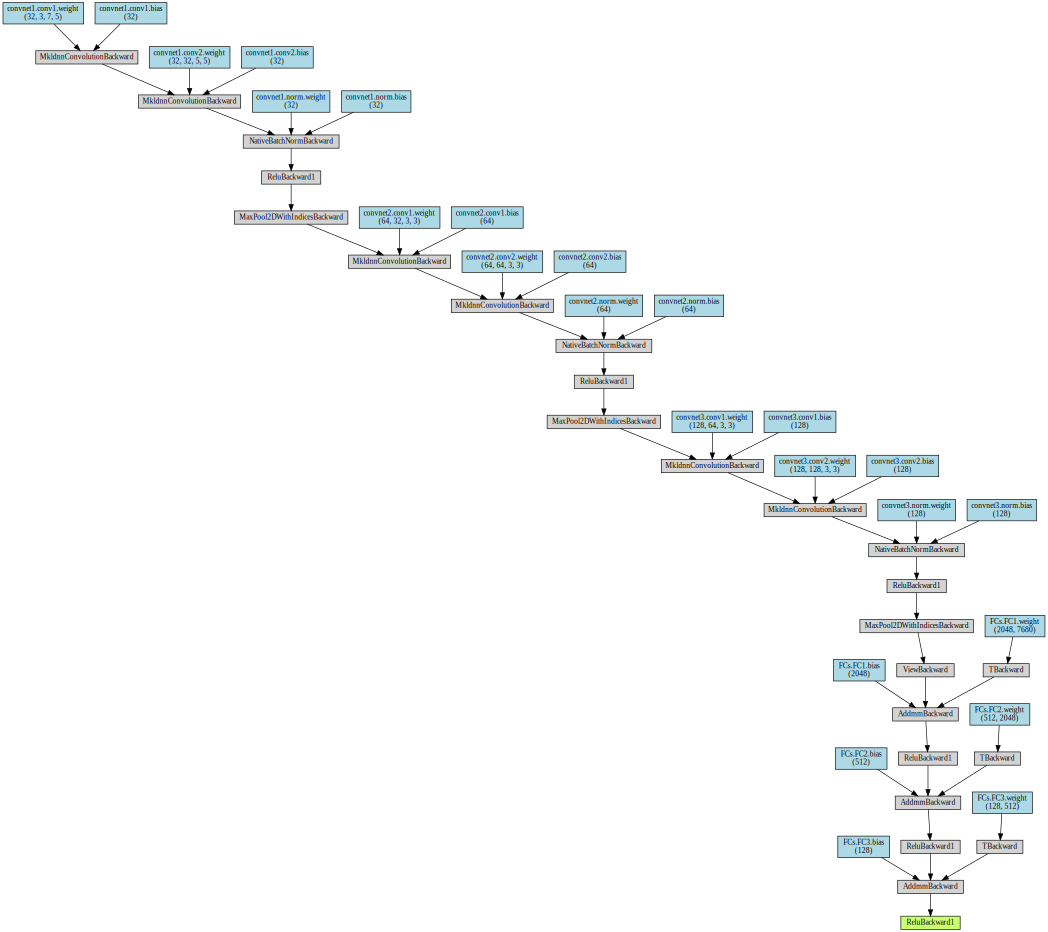

In [ ]:
from torchviz import make_dot

x = torch.randn(10,3,125,94)

make_dot(model(x), params=dict(model.named_parameters()))   

# ref : https://github.com/szagoruyko/pytorchviz/blob/master/examples.ipynb

In [ ]:
!pip install git+https://github.com/waleedka/hiddenlayer.git

  Cloning https://github.com/waleedka/hiddenlayer.git to /tmp/pip-req-build-p_6ry_vw
  Running command git clone -q https://github.com/waleedka/hiddenlayer.git /tmp/pip-req-build-p_6ry_vw
  Created wheel for hiddenlayer: filename=hiddenlayer-0.2-cp36-none-any.whl size=19771 sha256=6e617219ef97172c7c0ebabb961e1921e232a97f2ff82f92e7c6fa61d14bb0d7
  Stored in directory: /tmp/pip-ephem-wheel-cache-1mfd7y6p/wheels/49/bc/d1/938073704abdd049b3e4cdc6811c8f468d69fb5eecc6e01748
Successfully built hiddenlayer


/usr/local/lib/python3.6/dist-packages/torch/onnx/symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator batch_norm is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


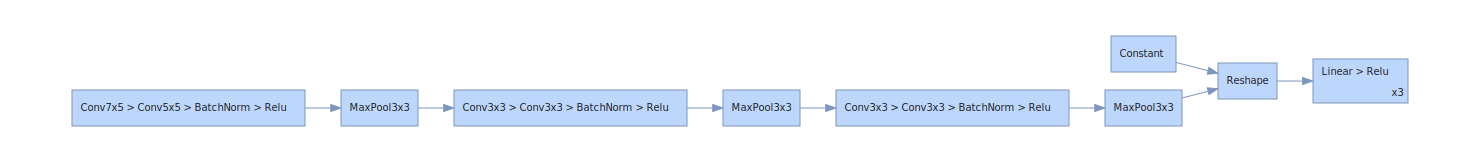

In [ ]:
import hiddenlayer as hl

# Build HiddenLayer graph
hl_graph = hl.build_graph(model, torch.zeros([10,3,125,94]))

# Use a different color theme
hl_graph.theme = hl.graph.THEMES["blue"].copy()  # Two options: basic and blue
hl_graph

#ref : https://github.com/waleedka/hiddenlayer/blob/master/demos/pytorch_graph.ipynb

## .

# TensorFlow

In [ ]:
import tensorflow as tf